# Data Collection for Timelines: Prep

This script takes the step after data collection of FAS_*.jsonl files to determine which timelines to collect.

In [4]:
import sys
sys.path.insert(0, '../src/d05_model_evaluation/')

from bispec_clustering_eval import BSCresults
from timeline_analysis import TimelineAnalyzer
import numpy as np
import plotnine
import os
import pandas as pd
import datetime
import pickle
import re
import scipy.signal
import matplotlib.pyplot as plt
import glob
import tqdm
import jsonlines
from collections import Counter

bscres = TimelineAnalyzer(
    '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/bsc/',  # bsc_dir
    '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/data',  # data_dir
)

In [5]:
# save bscres. Load in existing df.
search_query_text_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/search_hashtags.txt'

FAS_activity_df_long_with_zeros_path = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/FAS_peak_analysis/FAS_activity_df_long_with_zeros.obj'

if os.path.isfile(FAS_activity_df_long_with_zeros_path):
    with open(FAS_activity_df_long_with_zeros_path,'rb') as f:
        bscres.FAS_activity_df_long_with_zeros = pickle.load(f)
    print('file found and loaded')
else:
    bscres.plot_FAS_activity(search_query_text_file)
    with open(FAS_activity_df_long_with_zeros_path,'wb') as f:
        pickle.dump(bscres.FAS_activity_df_long_with_zeros, f)

file found and loaded


## Get peaks of each hashtag for the second step of data collection

### Pad the counts for each hashtag so that there are no missing days

In [6]:
# first convert to datetime
bscres.FAS_activity_df_long_with_zeros['created_at'] = pd.to_datetime(bscres.FAS_activity_df_long_with_zeros['created_at'])

# then set index to be created_at. This will help for the next step.
bscres.FAS_activity_df_long_with_zeros = bscres.FAS_activity_df_long_with_zeros.set_index('created_at')
# define function that will reindex the dataframe with dates. This is why we needed to set created_at as the index.
def reindex_by_date(df):
    df = df.reindex(pd.date_range(datetime.datetime(2017,10,16), datetime.
    datetime(2020,10,15)), fill_value = 0)
    df['hashtag'] = df['hashtag'].replace(to_replace=0, method='ffill')
    return df

# groupby each hashtag, then apply the function. Then the index needs to be reset so that we can reference the date by ['created_at']
z = bscres.FAS_activity_df_long_with_zeros.groupby('hashtag').apply(reindex_by_date).reset_index(0,drop=True).reset_index().rename(columns={'index':'created_at'})

# ensure the counts are integers
z['vocab:#'] = z['vocab:#'].astype(int)

# ensure the totals are not messed up
assert bscres.FAS_activity_df_long_with_zeros['vocab:#'].sum() == z['vocab:#'].sum()

# set equality
bscres.FAS_activity_df_long_with_zeros = z

# sanity check: the number of dates for each hashtag is correct.
assert (bscres.FAS_activity_df_long_with_zeros.groupby('hashtag').count()['vocab:#']==1096).all()

Actual peak finding, output results into a list for each hashtag

In [7]:
# actual peak finding.
# parameters for 2021-09-20: prominence = 0.9, distance=28, height = 0.05*max(z)

results = []
for hashtag in bscres.FAS_activity_df_long_with_zeros['hashtag'].unique():

    assert len(bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==hashtag]) == 1096
    z = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==hashtag]['vocab:#']
    peaks, peak_properties = scipy.signal.find_peaks(
        z,
        prominence = 0.9,
        distance=28,
        height = 0.05*max(z)
    )
    results.append((hashtag, peaks, peak_properties))

#print hashtags with no detected peaks:
for index, peakdetection in enumerate(results):
    if len(peakdetection[1]) == 0:
        print('{} at index {} has no peaks detected.'.format(peakdetection[0], index))

# this is because no instances of this hashtag were actually scraped. Possibly to be investigated, more likely just scrap it.
# bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==results[6][0]]['vocab:#'].max()

وأنا كمان at index 30 has no peaks detected.


Plot the detected peaks for each hashtag

In [8]:
skipped = 0
for index,peakdetection in enumerate(results):

    x = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==peakdetection[0]].loc[:,['vocab:#']] 

    # just check if figures already exist
    filename = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_05_04_16_22/FAS_peak_analysis/'+peakdetection[0]+'.jpg'

    if os.path.isfile(filename):
        skipped+=1
        continue

    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.plot(x.reset_index().loc[:,'vocab:#'])
    plt.plot(results[index][1], x.reset_index().loc[results[index][1],'vocab:#'].values.flatten(),"x")
    plt.savefig(filename,bbox_inches='tight')
    plt.close()

print('{} plots skipped because they already existed.'.format(skipped))

# continuity check
for hashtag in bscres.FAS_activity_df_long_with_zeros['hashtag'].unique():
    z = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==hashtag]
    first = datetime.datetime.strptime('2017-10-16', '%Y-%m-%d')
    for index,i in enumerate(z['created_at']):
        assert i == first, (index, i)
        first += datetime.timedelta(days=1)
print('continuity check for dates, all okay')

36 plots skipped because they already existed.
continuity check for dates, all okay


## Determining the users to collect

In [ ]:
# From the peaks collected, determine a window around each one to collect users from and get user ids to collect.

# old code to sanity check whether the max date for each file name is not included in that file
# for file in tqdm.tqdm(flist):
#     times=[]
#     with jsonlines.open(file) as reader:
#         for tweet_jsonl in reader:
#             tweet_list_in_file = tweet_jsonl['data']
#             for tweet_data in tweet_list_in_file:
#                 times.append(datetime.datetime.fromisoformat(tweet_data['created_at'][:-1]))
#     assert datetime.datetime.strptime(FAS_dates(os.path.split(file)[1])[1],'%Y-%m-%d') > max(times)
# print(min(times), max(times))

# N.B. END DATES OF FAS FILE TITLES ARE NOT INCLUSIVE


def FAS_dates(FAS_filename):
    return re.split('[_.]',FAS_filename)[1:3]

# print(FAS_dates('FAS_2017-10-16_2017-11-16.jsonl'))

# now sanity check: which dates are inclusive?
flist = glob.glob('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/collection_results_2021_06_19_16_21/data/FAS*.jsonl')

# quick bit of code to determine the index of the main metoo peak results
for i,e in enumerate(results):
    if e[0] == 'metoo':
        metoo_index = i
        break
print('metoo_index: {}'.format(metoo_index))

metoo_index: 8


In [ ]:
# collate peak locations. This is so that any overlaps can be smoothed out. This will then make the selection of which part to collect easier.

# first, take the peak locations of #metoo and treat those as bases around which to start collection. This strategy does NOT contain peaks that are not around #metoo peaks. THIS MAY NEED TO BE REVISED OR ADDED TO.

verbose = False

ranges = []
width = 21 # number of days to collect before and after each peak
for index, peak in enumerate(results[metoo_index][1]):
    ranges.append((max(0,peak-width), min(peak+width, 1096)))

if verbose:
    print(ranges)

def review_ranges(ranges):

    # define output list
    new_ranges = []

    # iterate over the ranges
    for index in range(len(ranges)):

        # if there already exists one entry in output list and the latest entry has a max date later than the early date in the current range iterating over, then we can continue the scanning. Otherwise, a prospective pair that is simply the current range is created. This allows the subsequent while loop.
        if len(new_ranges) > 0 and new_ranges[-1][1]>=ranges[index][0]:
            continue
        else:
            prospective_pair = ranges[index]
        ranges_index = index

        # if we have reached the end of ranges, we need to append whatever prospective pair we have.
        if index+1 == len(ranges):
            new_ranges.append(prospective_pair)
            break

        # create prospective pair. If the current range overlaps with the next one in ranges, then a prospective pair encompassing the current one needs to be created.
        if ranges[index][1] >= ranges[ranges_index+1][0]:
            prospective_pair = (ranges[index][0], ranges[ranges_index+1][1])
            ranges_index += 1

        while prospective_pair[1] >= ranges[ranges_index+1][0]:

            if verbose:
                print(prospective_pair)

            # depending on if the later date on the next range encompasses the current prospective max date or not, the update needs to be adapted.
            if prospective_pair[1] >= ranges[ranges_index+1][1]:

                prospective_pair = (ranges[index][0], prospective_pair[1])
                ranges_index += 1

            elif prospective_pair[1] < ranges[ranges_index+1][1]:

                prospective_pair = (ranges[index][0], ranges[ranges_index+1][1])
                ranges_index += 1

        # append prospective pair when no more updates need to be made
        new_ranges.append(prospective_pair)

    return new_ranges

if verbose:
    print(results[metoo_index][1])
    print(review_ranges(ranges))

# function that uses prominences to obtain a measure of strength of peaks captured within ranges proposed.
def range_strengths(reviewed_ranges, results):
    prominences = []
    for pair in reviewed_ranges:
        pair_prominence = 0
        # start at [1:] to skip #metoo
        no_peaks = True
        filtered_results = results[:metoo_index] + results[metoo_index+1:]
        for hashtag_peaks in filtered_results:
            for index, peak in enumerate(hashtag_peaks[1]):
                if peak > pair[0] and peak <= pair[1]:
                    no_peaks = False
                    pair_prominence += hashtag_peaks[2]['prominences'][index]
        if no_peaks:
            prominences.append(0)
        else:
            prominences.append(pair_prominence)

    return prominences

prominences = range_strengths(review_ranges(ranges), results)

if verbose:
    print(prominences)

width_normalised_prominences = [prom/(width[1]-width[0]) for width, prom in zip(review_ranges(ranges), prominences)]

In [ ]:
# converting 0-1083 back to dates

def unit_conv(val):
        return datetime.datetime.strptime('2017-10-16', '%Y-%m-%d') + datetime.timedelta(days=int(val))

def conv_to_date_ranges(ranges):
    return_ranges = []

    for pair in ranges:
        return_ranges.append((unit_conv(pair[0]), unit_conv(pair[1])))

    return return_ranges

dated_reviewed_ranges = conv_to_date_ranges(review_ranges(ranges))
# print(dated_reviewed_ranges)


[0.1740802  1.         0.01841376 0.10302605 0.6416833  0.11144836
 0.11211631 0.91936094 0.30085731 0.2540286 ]


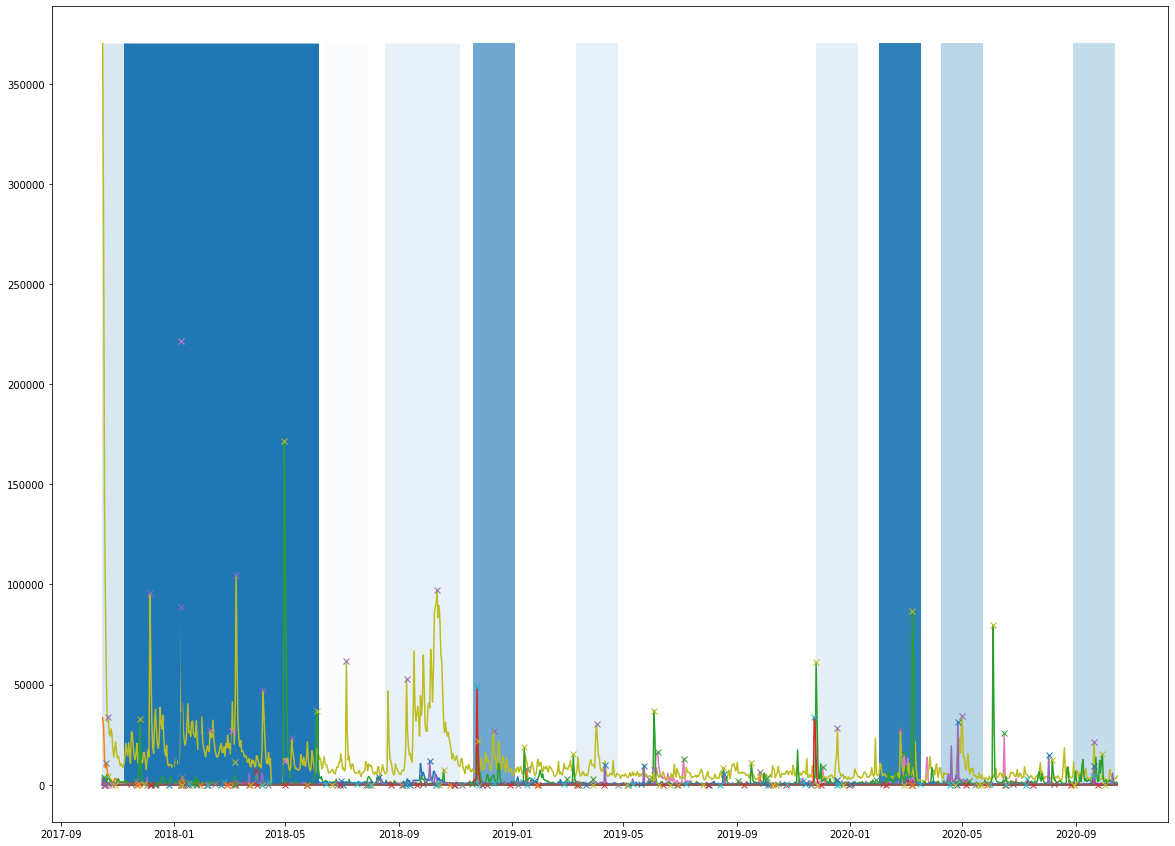

In [ ]:
#visualising the parts of the graph that will be sampled
bscres.FAS_activity_df_long = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['vocab:#']!=0]

# convert to datetime objects in column
bscres.FAS_activity_df_long_with_zeros['created_at'] = pd.to_datetime(bscres.FAS_activity_df_long_with_zeros['created_at'])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.vlines([i[0]+0.5*(i[1]-i[0]) for i in dated_reviewed_ranges],
    ymin = 0,
    ymax = bscres.FAS_activity_df_long_with_zeros['vocab:#'].max(),
    linewidth = [(i[1]-i[0]).days for i in dated_reviewed_ranges],
    # linewidth = 5,
    alpha = width_normalised_prominences/max(width_normalised_prominences)
    );
wide_data = bscres.FAS_activity_df_long_with_zeros.pivot(index='created_at', columns='hashtag', values='vocab:#')
# plt.plot('created_at','vocab:#', data = bscres.FAS_activity_df_long)
plt.plot(wide_data);

# also plot detected peaks
for peaksdetections in results:

    converted_peaks = np.array([unit_conv(i) for i in peaksdetections[1]])
    peak_plot_data = bscres.FAS_activity_df_long_with_zeros[bscres.FAS_activity_df_long_with_zeros['hashtag']==peaksdetections[0]]
    peak_plot_data = peak_plot_data[peak_plot_data['created_at'].isin(converted_peaks)].loc[:,['created_at','vocab:#']]
    plt.plot('created_at', 'vocab:#', 'x', data = peak_plot_data, )

print(width_normalised_prominences/max(width_normalised_prominences))

# plt.semilogy(basey=2)


### Get the users required for second data collection for blocks selected.